<a href="https://colab.research.google.com/github/svvema/ml-class-qt-pet-proj/blob/master/psb_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Импортируем библиотеки

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Подгружаем данные

In [ ]:
DATA_PATH = '/content/drive/MyDrive/pb_test/'

In [ ]:
df = pd.read_csv(DATA_PATH + 'task.csv', sep=';')
#df = pd.read_excel(DATA_PATH + 'task.xlsx')

In [ ]:
#df.to_csv(DATA_PATH + 'task.csv', sep=';', index=False)

In [ ]:
df.head()

,regNum,target,price,duration,revenue_post,days_from_first_sign_post_history,contracts_all_post_history,contracts_terminated_post_history,distance
0,X1,0,2400000.00,341,-99,745,8,0,0
1,X2,0,1228666.00,201,42165000,717,39,0,101
2,X3,0,1120009.68,364,420621000,1078,26,0,566
3,X4,0,1752594.92,109,525862000,83,4,0,566
4,X5,0,1098260.00,126,-99,853,45,0,1395


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912082 entries, 0 to 912081
Data columns (total 9 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   regNum                             912082 non-null  object 
 1   target                             912082 non-null  int64  
 2   price                              912082 non-null  float64
 3   duration                           912082 non-null  int64  
 4   revenue_post                       912082 non-null  int64  
 5   days_from_first_sign_post_history  912082 non-null  int64  
 6   contracts_all_post_history         912082 non-null  int64  
 7   contracts_terminated_post_history  912082 non-null  int64  
 8   distance                           912082 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 62.6+ MB


In [ ]:
df.describe()

,target,price,duration,revenue_post,days_from_first_sign_post_history,contracts_all_post_history,contracts_terminated_post_history,distance
count,912082.000000,9.120820e+05,912082.000000,9.120820e+05,912082.000000,912082.000000,912082.000000,912082.000000
mean,0.009419,3.326742e+06,188.376557,2.265072e+08,352.005383,78.686315,-36.171548,425.130580
std,0.096594,1.021238e+07,127.963678,5.400914e+08,370.017655,303.310510,47.706111,1002.127487
min,0.000000,0.000000e+00,0.000000,-1.640000e+05,-99.000000,-99.000000,-99.000000,0.000000
25%,0.000000,3.879520e+05,87.000000,-9.900000e+01,46.000000,2.000000,-99.000000,0.000000
50%,0.000000,1.257471e+06,178.000000,2.556400e+07,276.000000,12.000000,0.000000,0.000000
75%,0.000000,2.762734e+06,280.000000,1.486150e+08,599.000000,54.000000,0.000000,372.000000
max,1.000000,1.098166e+09,43828.000000,4.493357e+09,1490.000000,4631.000000,58.000000,7913.000000


Уровень расторжения контракта = 0.9419%

### Сформируем трейновую и тестовую выборки

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
test_idx = X_test['regNum']

In [ ]:
X_train.drop('regNum', axis=1, inplace=True)
X_test.drop('regNum', axis=1, inplace=True)

In [ ]:
y_train.mean()

0.009419585030785159

In [ ]:
y_test.mean()

0.009417999086340795

## WOE

In [ ]:
!pip install git+https://github.com/Falconwatch/riskpy.git@master

In [ ]:
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
X_train['target'] = y_train
X_test['target'] = y_test

In [ ]:
binner_ip = Binner()
bins = binner_ip.fit(X_train, 'target')
X_train_woe = binner_ip.transform(X_train)
X_test_woe = binner_ip.transform(X_test)

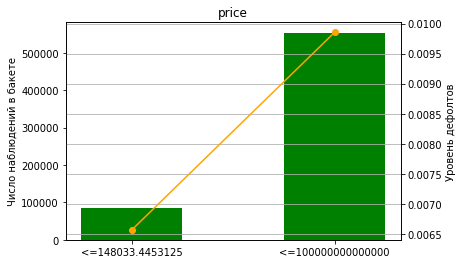

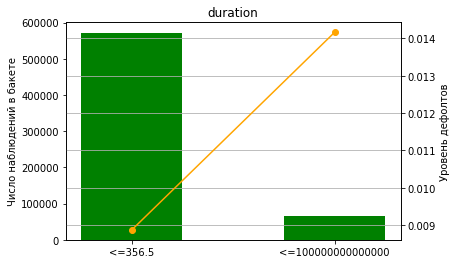

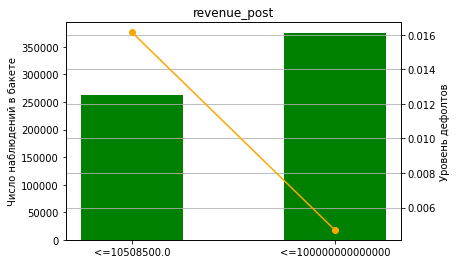

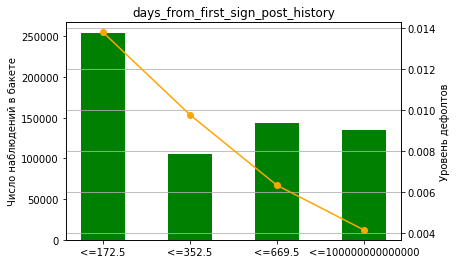

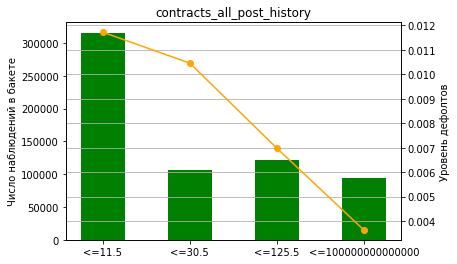

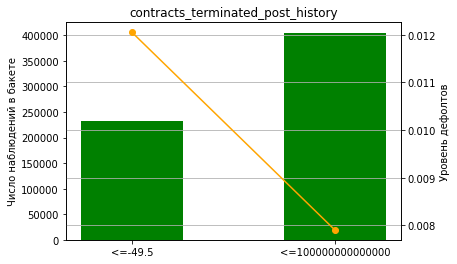

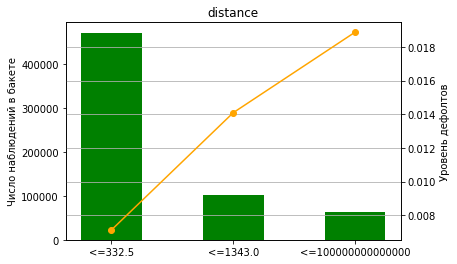

In [ ]:
binning_barchart(bins)

## GINI

In [ ]:
!pip install mlxtend --upgrade --no-deps
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from riskpy.modeling.modeler import Modeler

In [ ]:
modeler = Modeler(train_dataset=X_train_woe, test_dataset=X_test_woe, oot_dataset=None, target='target')

In [ ]:
gini_ofi=modeler.ExploreOneFactorImportance(X_train_woe.drop(['target'], axis=1).columns)

gini_ofi

,TRAIN,TEST
price_woe,0.040617,0.037410
duration_woe,0.052865,0.053819
revenue_post_woe,0.296747,0.293930
days_from_first_sign_post_history_woe,0.232726,0.237246
contracts_all_post_history_woe,0.162105,0.167776
contracts_terminated_post_history_woe,0.103160,0.090793
distance_woe,0.189813,0.196052


Удаляем признаки с коэффициентом Джини меньше 5%

In [ ]:
features = list(X_train_woe.drop(['target'], axis=1).columns)
features.remove('price_woe')

## Корреляция

In [ ]:
X_train_woe[features].corr()

,duration_woe,revenue_post_woe,days_from_first_sign_post_history_woe,contracts_all_post_history_woe,contracts_terminated_post_history_woe,distance_woe
duration_woe,1.000000,-0.041880,0.065823,-0.007013,0.102646,-0.093079
revenue_post_woe,-0.041880,1.000000,0.321690,0.215941,0.212296,-0.013629
days_from_first_sign_post_history_woe,0.065823,0.321690,1.000000,0.452119,0.720671,-0.059836
contracts_all_post_history_woe,-0.007013,0.215941,0.452119,1.000000,0.424147,-0.074604
contracts_terminated_post_history_woe,0.102646,0.212296,0.720671,0.424147,1.000000,-0.103171
distance_woe,-0.093079,-0.013629,-0.059836,-0.074604,-0.103171,1.000000


Удаляем признаки с корреляцией выше 0.5

In [ ]:
features.remove('contracts_terminated_post_history_woe')

Проверим что все коррелирующие признаки были убраны

In [ ]:
y_train_woe = X_train_woe['target']
y_test_woe = X_test_woe['target']
X_train_woe.drop(['target'], axis = 1, inplace = True)
X_test_woe.drop(['target'], axis = 1, inplace = True)

In [ ]:
FEATURE_COUNT = X_train_woe[features].shape[1]
N_SPLITS = 3

In [ ]:
search = {}
for i in range(1,FEATURE_COUNT + 1):
  logreg = LogisticRegression(random_state = 42, solver = 'liblinear', penalty = 'l1')
  skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = 42)

  selector = SFS(logreg, 
            k_features = i , 
            forward = True,  
            scoring ='roc_auc',
            cv = skf)

  selector = selector.fit(X_train_woe, y_train_woe)
  search[i] = selector.subsets_[i]['avg_score']
search

{1: 0.6483740870057001,
 2: 0.6913321924578885,
 3: 0.7065062471705675,
 4: 0.7164750504913084,
 5: 0.7201664787219131}

In [ ]:
X_train_woe_final = X_train_woe[features]
X_test_woe_final = X_test_woe[features]

### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.05, 0.3, 0.02)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_final, y_train_woe):
        
        X_train, X_test = X_train_woe_final.iloc[train_index,:], X_train_woe_final.iloc[test_index,:]
        y_train, y_test = y_train_woe.iloc[train_index], y_train_woe.iloc[test_index]
        logreg = LogisticRegression(random_state = 42, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

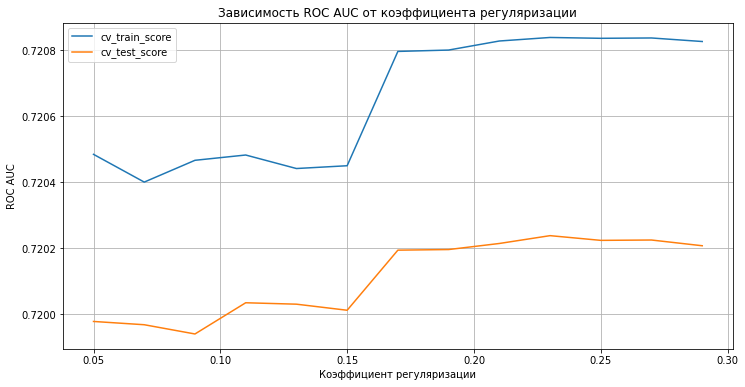

In [ ]:
plt.plot(alphas, cv_scores_train, label = 'cv_train_score')
plt.plot(alphas, cv_scores_test, label = 'cv_test_score')
plt.gcf().set_size_inches((12,6))
plt.grid()
plt.legend()
plt.title('Зависимость ROC AUC от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('ROC AUC')
plt.show()

In [ ]:
c_koef = round(alphas[np.argmax(cv_scores_test)],3)
print("Наилучший коэффициент регуляризации из рассмотренных:", c_koef)

Наилучший коэффициент регуляризации из рассмотренных: 0.23


Обучаем финальную модель на всем трейне

In [ ]:
logreg = LogisticRegression(random_state = 42, penalty = 'l2', C = c_koef)
logreg.fit(X_train_woe_final, y_train_woe)
y_pred = logreg.predict_proba(X_test_woe_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe, y_pred))

ROC AUC val: 0.7233214091372807


Подготовим для нашего теста скоринговую карту таким образом, что чем больше скор-балл, тем «лучше» контракт, то есть меньше вероятность его расторжения, чем меньше скор-балл, тем «хуже» контракт, то есть больше вероятность его расторжения

In [ ]:
pd.DataFrame({'regNum': test_idx.values, 'SCORE':logreg.predict_proba(X_test_woe_final)[:,0]})

,regNum,SCORE
0,X473107,0.995126
1,X213625,0.992498
2,X156519,0.990742
3,X111825,0.997516
4,X311678,0.998213
...,...,...
273620,X494856,0.995271
273621,X735940,0.960322
273622,X95847,0.989656
273623,X179111,0.973937
